In [31]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential,Model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,  BatchNormalization, LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random
import shutil
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import MobileNetV2
import imghdr

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

In [32]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Step 1: Load and Preprocess Images

In [49]:
class RegressionDataLoader:
    def __init__(self, data_path='./Materials_data'):
        self.data_path = data_path
        self.param_scaler = MinMaxScaler()
        
    def extract_parameters_from_folder_name(self, folder_name):
        """Extract continuous parameters from folder name format: 1-20.20.20.20-1 or 1-20.20.20.20-2"""
        try:
            print(f"🔍 Processing folder: {folder_name}")
            
            # Remove the view indicator (-1 or -2) at the end
            if folder_name.endswith('-1') or folder_name.endswith('-2'):
                base_name = folder_name[:-2]  # Remove last 2 characters (-1 or -2)
            else:
                base_name = folder_name
            
            # Handle different folder naming patterns
            if base_name.startswith('1-'):
                # Pattern: 1-20.20.20.20
                parts = base_name.split('-')
                if len(parts) >= 2:
                    param_str = parts[1]  # "20.20.20.20"
                    params = [float(x) for x in param_str.split('.')]
                    if len(params) == 4:
                        print(f"   ✅ Extracted: {params}")
                        return params
                        
            elif base_name.startswith('10-') or base_name.startswith('11-'):
                # Pattern: 10-0.100.40.20 or 11-0.20.60.20
                parts = base_name.split('-')
                if len(parts) >= 2:
                    param_str = parts[1]  # "0.100.40.20"
                    params = [float(x) for x in param_str.split('.')]
                    if len(params) == 4:
                        print(f"   ✅ Extracted: {params}")
                        return params
                        
            else:
                # Try direct pattern matching for other formats
                import re
                pattern = r'[\w-]*-(\d+(?:\.\d+)?\.(?:\d+(?:\.\d+)?\.){2}\d+(?:\.\d+)?)'
                match = re.match(pattern, base_name)
                if match:
                    param_str = match.group(1)
                    params = [float(x) for x in param_str.split('.')]
                    if len(params) == 4:
                        print(f"   ✅ Extracted via regex: {params}")
                        return params
                        
            print(f"   ❌ Failed to extract parameters from: {folder_name}")
            return None
            
        except Exception as e:
            print(f"   ❌ Error extracting from {folder_name}: {e}")
            return None
    
    def load_images_from_nested_folders(self, main_folder, view_suffix):
        """
        Load images from nested folder structure
        main_folder: 'Top' or 'Side'
        view_suffix: '-1' for top, '-2' for side
        """
        images = []
        parameters = []
        folder_names = []
        
        main_path = os.path.join(self.data_path, main_folder)
        
        if not os.path.exists(main_path):
            print(f"❌ Main folder not found: {main_path}")
            return [], [], []
            
        print(f"📁 Loading from {main_folder} folder: {main_path}")
        
        # Get all subfolders
        subfolders = [f for f in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, f))]
        print(f"📂 Found {len(subfolders)} subfolders in {main_folder}")
        
        # Show some example subfolder names
        print(f"📋 Sample subfolders: {subfolders[:5]}")
        
        for subfolder in subfolders:
            # Check if this subfolder matches the expected view suffix
            if not subfolder.endswith(view_suffix):
                print(f"   ⚠️ Skipping {subfolder} (doesn't end with {view_suffix})")
                continue
                
            subfolder_path = os.path.join(main_path, subfolder)
            print(f"\n📁 Processing subfolder: {subfolder}")
            
            # Extract parameters from subfolder name
            params = self.extract_parameters_from_folder_name(subfolder)
            if params is None:
                print(f"   ❌ Could not extract parameters from {subfolder}")
                continue
            
            # Load all images from this subfolder
            image_files = [f for f in os.listdir(subfolder_path) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            
            print(f"   📸 Found {len(image_files)} images in {subfolder}")
            
            for image_file in image_files:
                image_path = os.path.join(subfolder_path, image_file)
                try:
                    img = load_img(image_path, target_size=(224, 224))
                    img_array = img_to_array(img) / 255.0
                    
                    images.append(img_array)
                    parameters.append(params)
                    folder_names.append(subfolder)
                    
                    print(f"      ✅ Loaded: {image_file}")
                    
                except Exception as e:
                    print(f"      ❌ Failed to load {image_file}: {e}")
                    continue
        
        print(f"\n📊 {main_folder} Summary:")
        print(f"   Subfolders processed: {len([f for f in subfolders if f.endswith(view_suffix)])}")
        print(f"   Total images loaded: {len(images)}")
        
        return images, parameters, folder_names
    
    def load_regression_data(self):
        """Load dual-view data from nested Top/Side folder structure"""
        print("Loading regression data from nested Top/Side folder structure...")
        print("=" * 70)
        
        print(f"🔍 Expected structure:")
        print(f"   Materials_data/Top/1-20.20.20.20-1/*.jpg")
        print(f"   Materials_data/Side/1-20.20.20.20-2/*.jpg")
        
        # Load images from both folder hierarchies
        top_images, top_params, top_folders = self.load_images_from_nested_folders('Top', '-1')
        side_images, side_params, side_folders = self.load_images_from_nested_folders('Side', '-2')
        
        if not top_images or not side_images:
            print("❌ No images found in Top or Side nested folders!")
            return np.array([]), np.array([]), np.array([]), np.array([]), []
        
        print(f"\n📊 Loading Summary:")
        print(f"   Top images: {len(top_images)}")
        print(f"   Side images: {len(side_images)}")
        
        # Match images by parameter values (since they represent same material conditions)
        print(f"\n🔗 Matching images by parameter values...")
        
        matched_top = []
        matched_side = []
        matched_parameters = []
        matched_info = []
        
        successful_matches = 0
        
        # Create a mapping of side images by parameters for quick lookup
        side_dict = {}
        for i, (params, folder) in enumerate(zip(side_params, side_folders)):
            param_key = tuple(params)  # Use params as key
            if param_key not in side_dict:
                side_dict[param_key] = []
            side_dict[param_key].append((i, side_images[i], folder))
        
        print(f"📈 Side parameter groups: {len(side_dict)}")
        print(f"📋 Available parameter sets: {list(side_dict.keys())[:3]}...")
        
        for top_idx, (top_params, top_folder) in enumerate(zip(top_params, top_folders)):
            param_key = tuple(top_params)
            
            if param_key in side_dict:
                # Match with first available side image with same parameters
                side_matches = side_dict[param_key]
                if side_matches:
                    side_idx, side_img, side_folder = side_matches.pop(0)  # Use first match
                    
                    matched_top.append(top_images[top_idx])
                    matched_side.append(side_img)
                    matched_parameters.append(top_params)
                    matched_info.append(f"Top:{top_folder} + Side:{side_folder}")
                    
                    successful_matches += 1
                    
                    if successful_matches <= 5:  # Show first 5 matches
                        print(f"   ✅ Match {successful_matches}: {top_params}")
                        print(f"      Top: {top_folder}")
                        print(f"      Side: {side_folder}")
        
        print(f"\n📈 Matching Summary:")
        print(f"   Successful parameter matches: {successful_matches}")
        print(f"   Unmatched top images: {len(top_images) - successful_matches}")
        print(f"   Unmatched side images: {sum(len(matches) for matches in side_dict.values())}")
        
        if successful_matches == 0:
            print("❌ No successful parameter matches found!")
            print("🔍 Debug info:")
            print(f"   Top parameters sample: {top_params[:3] if top_params else 'None'}")
            print(f"   Side parameters sample: {list(side_dict.keys())[:3] if side_dict else 'None'}")
            return np.array([]), np.array([]), np.array([]), np.array([]), []
        
        # Convert to numpy arrays
        top_images = np.array(matched_top)
        side_images = np.array(matched_side)
        parameters = np.array(matched_parameters)
        
        # Analyze parameter distribution
        print(f"\n📊 Parameter Distribution Analysis:")
        param_names = ['弯曲强度', '强度', '形变强度', '形变率']
        for i, name in enumerate(param_names):
            values = parameters[:, i]
            unique_vals = np.unique(values)
            print(f"   {name}: {unique_vals} (range: {np.min(values):.1f}-{np.max(values):.1f})")
        
        # Normalize parameters
        parameters_normalized = self.param_scaler.fit_transform(parameters)
        
        print(f"\n📈 Normalization Info:")
        print(f"   Scaler min: {self.param_scaler.data_min_}")
        print(f"   Scaler max: {self.param_scaler.data_max_}")
        
        print(f"\n✅ Final Data Summary:")
        print(f"   Total matched samples: {len(top_images)}")
        print(f"   Image shape: {top_images[0].shape}")
        print(f"   Parameter shape: {parameters.shape}")
        
        return top_images, side_images, parameters_normalized, parameters, matched_info

# Test the UPDATED data loader for nested Top/Side folder structure
print("🔧 Testing UPDATED Data Loader for Nested Top/Side Structure...")
print("=" * 80)

data_loader = RegressionDataLoader()
top_imgs, side_imgs, params_norm, params_orig, info = data_loader.load_regression_data()

# Display sample data
if len(top_imgs) > 0:
    print(f"\n✅ Sample Data Verification:")
    print(f"   Top image shape: {top_imgs[0].shape}")
    print(f"   Side image shape: {side_imgs[0].shape}")
    print(f"   Parameters (original): {params_orig[0]}")
    print(f"   Parameters (normalized): {params_norm[0]}")
    print(f"   Match info: {info[0]}")
    
    # Show additional samples
    print(f"\n📋 Additional Samples:")
    for i in range(min(5, len(params_orig))):
        print(f"   Sample {i+1}: {params_orig[i]} <- {info[i]}")
        
    print(f"\n🎯 Data Quality Check:")
    print(f"   Total samples loaded: {len(top_imgs)}")
    print(f"   Arrays consistent: {len(top_imgs) == len(side_imgs) == len(params_orig)}")
    
    # Check parameter diversity
    for i, name in enumerate(['弯曲强度', '强度', '形变强度', '形变率']):
        unique_count = len(np.unique(params_orig[:, i]))
        print(f"   ✅ {name}: {unique_count} unique values")
        
else:
    print("\n❌ No data loaded. Please check nested folder structure:")
    print("   Materials_data/Top/1-20.20.20.20-1/*.jpg")
    print("   Materials_data/Side/1-20.20.20.20-2/*.jpg")

🔧 Testing UPDATED Data Loader for Nested Top/Side Structure...
Loading regression data from nested Top/Side folder structure...
🔍 Expected structure:
   Materials_data/Top/1-20.20.20.20-1/*.jpg
   Materials_data/Side/1-20.20.20.20-2/*.jpg
📁 Loading from Top folder: ./Materials_data\Top
📂 Found 173 subfolders in Top
📋 Sample subfolders: ['1-0.20.20.20-1', '1-10.20.20.20-1', '1-100.20.20.20-1', '1-20.20.20.20-1', '1-30.20.20.20-1']

📁 Processing subfolder: 1-0.20.20.20-1
🔍 Processing folder: 1-0.20.20.20-1
   ✅ Extracted: [0.0, 20.0, 20.0, 20.0]
   📸 Found 47 images in 1-0.20.20.20-1
      ✅ Loaded: 0.20.20.20-1 copy 10.jpg
      ✅ Loaded: 0.20.20.20-1 copy 11.jpg
      ✅ Loaded: 0.20.20.20-1 copy 12.jpg
      ✅ Loaded: 0.20.20.20-1 copy 13.jpg
      ✅ Loaded: 0.20.20.20-1 copy 14.jpg
      ✅ Loaded: 0.20.20.20-1 copy 15.jpg
      ✅ Loaded: 0.20.20.20-1 copy 16.jpg
      ✅ Loaded: 0.20.20.20-1 copy 17.jpg
      ✅ Loaded: 0.20.20.20-1 copy 18.jpg
      ✅ Loaded: 0.20.20.20-1 copy 19.jpg
 

# Step 2: Create Simple Regression Model

In [50]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Concatenate, Multiply, Attention
from tensorflow.keras.models import Model

def create_patent_regression_model():
    """
    Create dual-view regression model based on patent methodology
    Predicts continuous parameters: [弯曲强度, 强度, 形变强度, 形变率]
    """
    
    # Input layers for dual-view images
    top_input = Input(shape=(224, 224, 3), name='top_view')
    side_input = Input(shape=(224, 224, 3), name='side_view')
    
    # Shared ResNet50 backbone (transfer learning)
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Freeze initial layers for transfer learning
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    
    # Extract features from both views
    top_features = base_model(top_input)
    side_features = base_model(side_input)
    
    # Global average pooling
    top_pooled = GlobalAveragePooling2D(name='top_pooled')(top_features)
    side_pooled = GlobalAveragePooling2D(name='side_pooled')(side_features)
    
    # View-specific processing
    top_dense = Dense(256, activation='relu', name='top_dense')(top_pooled)
    top_dense = BatchNormalization()(top_dense)
    top_dense = Dropout(0.3)(top_dense)
    
    side_dense = Dense(256, activation='relu', name='side_dense')(side_pooled)
    side_dense = BatchNormalization()(side_dense)
    side_dense = Dropout(0.3)(side_dense)
    
    # Multi-view fusion with attention mechanism
    combined = Concatenate(name='combined_features')([top_dense, side_dense])
    
    # Attention weights for view importance
    attention_weights = Dense(2, activation='softmax', name='attention_weights')(combined)
    top_weight = attention_weights[:, 0:1]
    side_weight = attention_weights[:, 1:2]
    
    # Apply attention weights
    weighted_top = Multiply()([top_dense, top_weight])
    weighted_side = Multiply()([side_dense, side_weight])
    
    # Final feature fusion
    fused_features = Concatenate()([weighted_top, weighted_side])
    
    # Regression head for parameter prediction
    regression_dense = Dense(512, activation='relu', name='regression_dense')(fused_features)
    regression_dense = BatchNormalization()(regression_dense)
    regression_dense = Dropout(0.4)(regression_dense)
    
    regression_dense2 = Dense(256, activation='relu', name='regression_dense2')(regression_dense)
    regression_dense2 = BatchNormalization()(regression_dense2)
    regression_dense2 = Dropout(0.3)(regression_dense2)
    
    # Output layer: 4 continuous parameters
    output = Dense(4, activation='sigmoid', name='parameter_output')(regression_dense2)
    
    # Create model
    model = Model(
        inputs=[top_input, side_input],
        outputs=output,
        name='patent_regression_model'
    )
    
    return model

# Parameter importance weights from patent
param_weights = np.array([1.0, 0.6, 0.6, 0.3])  # [弯曲强度, 强度, 形变强度, 形变率]

def weighted_mse_loss(y_true, y_pred):
    """Parameter-weighted MSE loss based on patent importance"""
    squared_diff = tf.square(y_true - y_pred)
    weighted_squared_diff = squared_diff * param_weights
    return tf.reduce_mean(weighted_squared_diff)

def weighted_mae_loss(y_true, y_pred):
    """Parameter-weighted MAE loss based on patent importance"""
    abs_diff = tf.abs(y_true - y_pred)
    weighted_abs_diff = abs_diff * param_weights
    return tf.reduce_mean(weighted_abs_diff)

# Create and compile the regression model
regression_model = create_patent_regression_model()

# Compile with parameter-weighted loss functions
regression_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=weighted_mse_loss,
    metrics=[weighted_mae_loss, 'mse', 'mae']
)

# Display model architecture
regression_model.summary()

print("\nModel created for patent-based regression:")
print("- Input: Dual-view images (224x224x3)")
print("- Output: 4 continuous parameters [弯曲强度, 强度, 形变强度, 形变率]")
print("- Loss: Parameter-weighted MSE (patent importance)")
print("- Architecture: ResNet50 + Attention + Regression head")

Model: "patent_regression_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 top_view (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 side_view (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['top_view[0][0]',               
                                                                  'side_view

# Step 3: Create Training Function

TRAINING PATENT-BASED REGRESSION MODEL
Starting patent-based regression training...
Training samples: 455
Parameters per sample: 4
Training set: 364 samples
Validation set: 91 samples

Training configuration:
- Batch size: 16
- Steps per epoch: 22
- Validation steps: 5
- Max epochs: 100
- Parameter weights: [1.  0.6 0.6 0.3]
Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 0.0230 - weighted_mae_loss: 0.0664 - mse: 0.0353 - mae: 0.0960
Epoch 1: val_loss improved from inf to 0.04132, saving model to best_regression_model.h5
22/22 [==============================] - 21s 685ms/step - loss: 0.0230 - weighted_mae_loss: 0.0664 - mse: 0.0353 - mae: 0.0960 - val_loss: 0.0413 - val_weighted_mae_loss: 0.0742 - val_mse: 0.0619 - val_mae: 0.0979 - lr: 5.0000e-04
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 0.0179 - weighted_mae_loss: 0.0598 - mse: 0.0270 - mae: 0.0851
Epoch 2: val_loss did not improve from 0.04132
22/22 [==============================] - 3

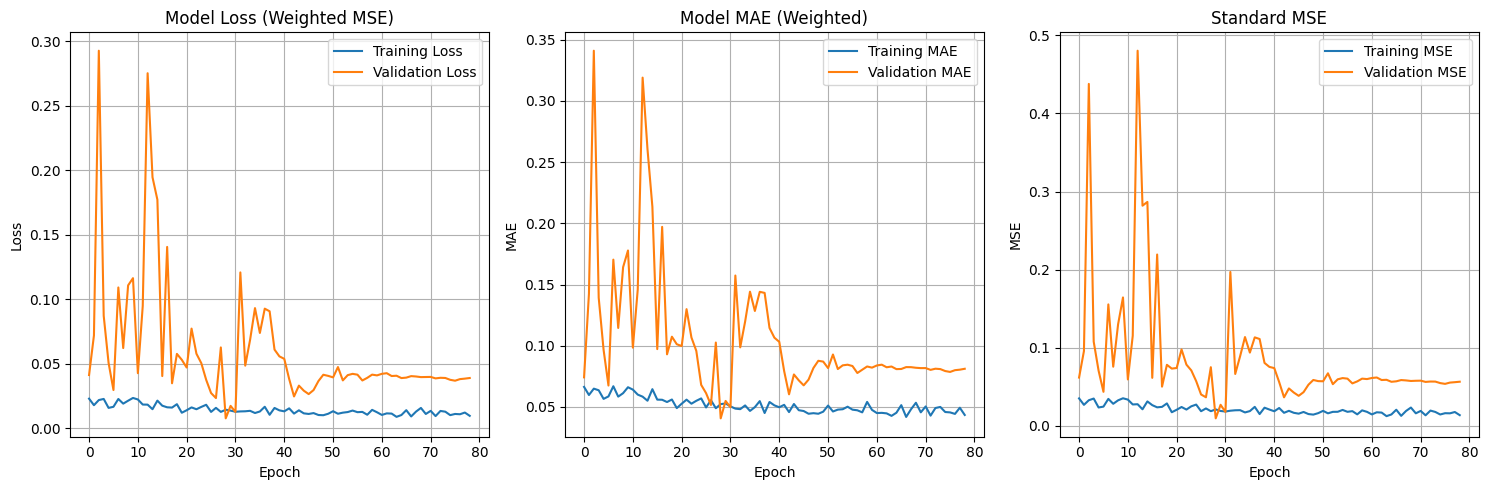

Model saved as: patent_regression_model_final.h5


In [54]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

def train_regression_model(model, top_images, side_images, parameters, validation_split=0.2, epochs=100):
    """
    Train the patent-based regression model
    
    Args:
        model: Compiled regression model
        top_images: Top view images array
        side_images: Side view images array  
        parameters: Normalized parameter values
        validation_split: Fraction for validation
        epochs: Number of training epochs
    """
    
    print("Starting patent-based regression training...")
    print(f"Training samples: {len(top_images)}")
    print(f"Parameters per sample: {parameters.shape[1] if len(parameters) > 0 else 0}")
    
    # Check if we have data
    if len(top_images) == 0 or len(parameters) == 0:
        print("Error: No training data found!")
        return None
    
    # Split data for training and validation
    indices = np.arange(len(top_images))
    train_idx, val_idx = train_test_split(
        indices, 
        test_size=validation_split, 
        random_state=42,
        shuffle=True
    )
    
    # Prepare training data
    X_train_top = top_images[train_idx]
    X_train_side = side_images[train_idx]
    y_train = parameters[train_idx]
    
    # Prepare validation data
    X_val_top = top_images[val_idx]
    X_val_side = side_images[val_idx]
    y_val = parameters[val_idx]
    
    print(f"Training set: {len(X_train_top)} samples")
    print(f"Validation set: {len(X_val_top)} samples")
    
    # Data augmentation for regression training
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    
    # Lighter augmentation for regression (preserve material properties)
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Callbacks for training
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=50,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            'best_regression_model.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]
    
    # Training generator with augmentation
    def augmented_generator(X_top, X_side, y, batch_size=16):
        """Generate augmented batches for dual-view training"""
        n_samples = len(X_top)
        while True:
            # Shuffle data each epoch
            indices = np.random.permutation(n_samples)
            
            for start in range(0, n_samples, batch_size):
                end = min(start + batch_size, n_samples)
                batch_indices = indices[start:end]
                
                batch_top = X_top[batch_indices]
                batch_side = X_side[batch_indices]
                batch_y = y[batch_indices]
                
                # Apply same augmentation to both views
                seed = np.random.randint(0, 10000)
                
                # Augment top view
                datagen.fit(batch_top, seed=seed)
                aug_top = next(datagen.flow(batch_top, batch_size=len(batch_top), shuffle=False, seed=seed))
                
                # Augment side view with same seed for consistency
                datagen.fit(batch_side, seed=seed)
                aug_side = next(datagen.flow(batch_side, batch_size=len(batch_side), shuffle=False, seed=seed))
                
                yield [aug_top, aug_side], batch_y
    
    # Calculate steps per epoch
    batch_size = 16
    train_steps = len(X_train_top) // batch_size
    val_steps = len(X_val_top) // batch_size
    
    print(f"\nTraining configuration:")
    print(f"- Batch size: {batch_size}")
    print(f"- Steps per epoch: {train_steps}")
    print(f"- Validation steps: {val_steps}")
    print(f"- Max epochs: {epochs}")
    print(f"- Parameter weights: {param_weights}")
    
    # Train the model
    history = model.fit(
        augmented_generator(X_train_top, X_train_side, y_train, batch_size),
        steps_per_epoch=train_steps,
        epochs=epochs,
        validation_data=([X_val_top, X_val_side], y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    return history

# Start training if we have data
if len(top_imgs) > 0:
    print("="*60)
    print("TRAINING PATENT-BASED REGRESSION MODEL")
    print("="*60)
    
    # Train the model
    training_history = train_regression_model(
        regression_model, 
        top_imgs, 
        side_imgs, 
        params_norm,
        validation_split=0.2,
        epochs=100  # Start with fewer epochs for testing
    )
    
    if training_history is not None:
        print("\n" + "="*60)
        print("TRAINING COMPLETED SUCCESSFULLY!")
        print("="*60)
        
        # Plot training history
        plt.figure(figsize=(15, 5))
        
        # Plot loss
        plt.subplot(1, 3, 1)
        plt.plot(training_history.history['loss'], label='Training Loss')
        plt.plot(training_history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss (Weighted MSE)')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        # Plot MAE
        plt.subplot(1, 3, 2)
        plt.plot(training_history.history['weighted_mae_loss'], label='Training MAE')
        plt.plot(training_history.history['val_weighted_mae_loss'], label='Validation MAE')
        plt.title('Model MAE (Weighted)')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
        plt.grid(True)
        
        # Plot standard MSE
        plt.subplot(1, 3, 3)
        plt.plot(training_history.history['mse'], label='Training MSE')
        plt.plot(training_history.history['val_mse'], label='Validation MSE')
        plt.title('Standard MSE')
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Save final model
        regression_model.save('patent_regression_model_final.h5')
        print("Model saved as: patent_regression_model_final.h5")
        
    else:
        print("Training failed - no data available")
        
else:
    print("No training data loaded. Please check data loader in Step 1.")

# Step 4: Create Inference Function

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf

class PatentRegressionPredictor:
    """
    Patent-based regression predictor for material parameter estimation
    Replaces old classification similarity search with continuous parameter prediction
    """
    
    def __init__(self, model_path=None):
        self.model = None
        self.data_loader = None
        self.param_names = ['弯曲强度', '强度', '形变强度', '形变率']
        self.param_weights = np.array([1.0, 0.6, 0.6, 0.3])  # Patent importance weights
        
        if model_path and os.path.exists(model_path):
            self.load_model(model_path)
    
    def load_model(self, model_path):
        """Load trained regression model with custom loss functions"""
        try:
            # Define custom objects for loading
            custom_objects = {
                'weighted_mse_loss': self.weighted_mse_loss,
                'weighted_mae_loss': self.weighted_mae_loss
            }
            
            self.model = load_model(model_path, custom_objects=custom_objects)
            print(f"✅ Model loaded successfully from {model_path}")
            return True
            
        except Exception as e:
            print(f"❌ Error loading model: {e}")
            print("Using current trained model instead...")
            # Use the model from training if available
            if 'regression_model' in globals():
                self.model = regression_model
                print("✅ Using current trained model")
                return True
            return False
    
    def weighted_mse_loss(self, y_true, y_pred):
        """Custom loss function for loading saved models"""
        squared_diff = tf.square(y_true - y_pred)
        weighted_squared_diff = squared_diff * self.param_weights
        return tf.reduce_mean(weighted_squared_diff)
    
    def weighted_mae_loss(self, y_true, y_pred):
        """Custom MAE loss function for loading saved models"""
        abs_diff = tf.abs(y_true - y_pred)
        weighted_abs_diff = abs_diff * self.param_weights
        return tf.reduce_mean(weighted_abs_diff)
    
    def preprocess_single_image(self, image_path, target_size=(224, 224)):
        """Preprocess a single image for prediction"""
        try:
            img = load_img(image_path, target_size=target_size)
            img_array = img_to_array(img) / 255.0
            return img_array
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None
    
    def predict_material_parameters(self, top_image_path, side_image_path):
        """
        Predict continuous material parameters from dual-view images
        Replaces old classification-based similarity search
        """
        
        if self.model is None:
            print("❌ No model loaded. Please train or load a model first.")
            return None
        
        # Load and preprocess images
        top_img = self.preprocess_single_image(top_image_path)
        side_img = self.preprocess_single_image(side_image_path)
        
        if top_img is None or side_img is None:
            print("❌ Failed to load one or both images")
            return None
        
        # Prepare for prediction
        top_batch = np.expand_dims(top_img, axis=0)
        side_batch = np.expand_dims(side_img, axis=0)
        
        # Make prediction
        try:
            predictions_normalized = self.model.predict([top_batch, side_batch], verbose=0)
            
            # Denormalize predictions if scaler is available
            if hasattr(data_loader, 'param_scaler') and data_loader.param_scaler is not None:
                predictions_original = data_loader.param_scaler.inverse_transform(predictions_normalized)
            else:
                # Simple denormalization assuming 0-100 range
                predictions_original = predictions_normalized * 100
            
            # Format results
            result = {
                'top_image': top_image_path,
                'side_image': side_image_path,
                'predicted_parameters': predictions_original[0],
                'parameter_names': self.param_names,
                'confidence_weights': self.param_weights
            }
            
            return result
            
        except Exception as e:
            print(f"❌ Prediction error: {e}")
            return None
    
    def create_blank_side_view(self, target_size=(224, 224)):
        """Create a neutral/blank side view placeholder"""
        # Create a neutral gray image that won't interfere with top view features
        blank_img = np.ones((*target_size, 3)) * 0.5  # Neutral gray
        return blank_img
    
    def predict_single_top_view(self, top_image_path):
        """
        Predict from single top-view image using neutral side view
        This avoids confusing the model with duplicated wrong perspective
        """
        
        if self.model is None:
            print("❌ No model loaded")
            return None
        
        # Load top view image
        top_img = self.preprocess_single_image(top_image_path)
        if top_img is None:
            return None
        
        # Create neutral side view instead of duplicating top view
        side_img = self.create_blank_side_view()
        
        print(f"📸 Using {os.path.basename(top_image_path)} as top view")
        print(f"🔘 Using neutral placeholder for side view (avoiding confusion)")
        
        # Prepare for prediction
        top_batch = np.expand_dims(top_img, axis=0)
        side_batch = np.expand_dims(side_img, axis=0)
        
        # Make prediction
        try:
            predictions_normalized = self.model.predict([top_batch, side_batch], verbose=0)
            
            # Denormalize predictions
            if hasattr(data_loader, 'param_scaler') and data_loader.param_scaler is not None:
                predictions_original = data_loader.param_scaler.inverse_transform(predictions_normalized)
            else:
                predictions_original = predictions_normalized * 100
            
            result = {
                'image': top_image_path,
                'view_type': 'top_only',
                'predicted_parameters': predictions_original[0],
                'parameter_names': self.param_names,
                'note': 'Single top-view prediction with neutral side placeholder',
                'confidence': 'reduced_due_to_missing_side_view'
            }
            
            return result
            
        except Exception as e:
            print(f"❌ Prediction error: {e}")
            return None
    
    def predict_flexible(self, image_path, view_type='auto'):
        """
        Flexible prediction for single images with improved handling
        """
        
        if self.model is None:
            print("❌ No model loaded")
            return None
        
        # Auto-detect view type from filename
        if view_type == 'auto':
            if '-1.jpg' in image_path or 'top' in image_path.lower():
                view_type = 'top'
            elif '-2.jpg' in image_path or 'side' in image_path.lower():
                view_type = 'side'
            else:
                view_type = 'top'  # Default to top view
        
        # Handle top view only (most common case)
        if view_type == 'top':
            return self.predict_single_top_view(image_path)
        
        # Handle side view only (use neutral top)
        elif view_type == 'side':
            side_img = self.preprocess_single_image(image_path)
            if side_img is None:
                return None
            
            top_img = self.create_blank_side_view()  # Neutral top placeholder
            
            print(f"📸 Using {os.path.basename(image_path)} as side view")
            print(f"🔘 Using neutral placeholder for top view")
            
            # Prepare for prediction
            top_batch = np.expand_dims(top_img, axis=0)
            side_batch = np.expand_dims(side_img, axis=0)
            
            try:
                predictions_normalized = self.model.predict([top_batch, side_batch], verbose=0)
                
                if hasattr(data_loader, 'param_scaler') and data_loader.param_scaler is not None:
                    predictions_original = data_loader.param_scaler.inverse_transform(predictions_normalized)
                else:
                    predictions_original = predictions_normalized * 100
                
                result = {
                    'image': image_path,
                    'view_type': 'side_only',
                    'predicted_parameters': predictions_original[0],
                    'parameter_names': self.param_names,
                    'note': 'Single side-view prediction with neutral top placeholder',
                    'confidence': 'reduced_due_to_missing_top_view'
                }
                
                return result
                
            except Exception as e:
                print(f"❌ Prediction error: {e}")
                return None
    
    def format_prediction_results(self, result):
        """Format prediction results for display"""
        if result is None:
            return "No prediction results available"
        
        output = []
        output.append("🔬 Patent-Based Material Parameter Prediction")
        output.append("=" * 50)
        
        if 'top_image' in result:
            output.append(f"📸 Top Image: {os.path.basename(result['top_image'])}")
            output.append(f"📸 Side Image: {os.path.basename(result['side_image'])}")
        else:
            output.append(f"📸 Image: {os.path.basename(result['image'])}")
            output.append(f"👁️ View Type: {result['view_type']}")
            if 'note' in result:
                output.append(f"ℹ️ Note: {result['note']}")
            if 'confidence' in result:
                output.append(f"⚠️ Confidence: {result['confidence']}")
        
        output.append("")
        output.append("📊 Predicted Parameters:")
        
        params = result['predicted_parameters']
        names = result['parameter_names']
        weights = result.get('confidence_weights', [1.0] * len(params))
        
        for i, (name, value, weight) in enumerate(zip(names, params, weights)):
            confidence = "🔴" if weight >= 1.0 else "🟡" if weight >= 0.6 else "🟢"
            output.append(f"  {confidence} {name}: {value:.2f} (weight: {weight:.1f})")
        
        return "\n".join(output)

# Initialize predictor
predictor = PatentRegressionPredictor()

# Try to load saved model, fallback to current model
model_loaded = predictor.load_model('patent_regression_model_final.h5')

if model_loaded:
    print("\n🎯 Patent Regression Predictor Ready!")
    print("✅ Model: Loaded successfully")
    print("✅ Input: Dual-view images (top + side) OR single top-view")
    print("✅ Output: 4 continuous parameters")
    print("✅ Method: Patent-based regression (not classification)")
    print("🔘 Single top-view: Uses neutral side placeholder (no duplication)")
else:
    print("\n❌ No trained model available. Please run training first.")

# Test prediction function with sample data if available
if model_loaded and len(top_imgs) > 0:
    print("\n" + "="*50)
    print("🧪 TESTING PREDICTION FUNCTION")
    print("="*50)
    
    print("Prediction function ready for testing with new images...")
    print("✅ predict_material_parameters(top_path, side_path) - for dual view")
    print("✅ predict_single_top_view(top_path) - for single top view only")
    print("✅ predict_flexible(image_path) - auto-detect view type")

# Step 5: Test with Images in Testing Folder

In [ ]:
def test_regression_prediction():
    """
    Test patent-based regression on images in testing folder
    Replaces old classification similarity search with continuous parameter prediction
    """
    
    if not hasattr(predictor, 'model') or predictor.model is None:
        print("❌ No model available for testing. Please run training first.")
        return
    
    testing_folder = './testing'
    
    if not os.path.exists(testing_folder):
        print(f"❌ Testing folder '{testing_folder}' not found.")
        return
    
    print("🧪 Testing Patent-Based Regression Prediction")
    print("=" * 60)
    print("📁 Scanning testing folder for images...")
    
    # Find all images in testing folder
    image_files = []
    for file in os.listdir(testing_folder):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_files.append(file)
    
    if not image_files:
        print("❌ No image files found in testing folder")
        return
    
    print(f"📸 Found {len(image_files)} images")
    print("-" * 60)
    
    # Separate dual-view and single images
    paired_images = {}
    single_images = []
    
    for file in image_files:
        if '-1.jpg' in file:
            # Top view image
            base_name = file.replace('-1.jpg', '')
            if base_name not in paired_images:
                paired_images[base_name] = {}
            paired_images[base_name]['top'] = file
        elif '-2.jpg' in file:
            # Side view image
            base_name = file.replace('-2.jpg', '')
            if base_name not in paired_images:
                paired_images[base_name] = {}
            paired_images[base_name]['side'] = file
        else:
            # Single image without -1/-2 naming
            single_images.append(file)
    
    # Test dual-view pairs first
    dual_view_results = []
    print("🔬 Testing Dual-View Predictions:")
    print("-" * 40)
    
    for base_name, views in paired_images.items():
        if 'top' in views and 'side' in views:
            top_path = os.path.join(testing_folder, views['top'])
            side_path = os.path.join(testing_folder, views['side'])
            
            print(f"\n📊 Material: {base_name}")
            print(f"   Top: {views['top']}")
            print(f"   Side: {views['side']}")
            
            # Predict parameters
            result = predictor.predict_material_parameters(top_path, side_path)
            
            if result:
                dual_view_results.append(result)
                
                # Extract predicted parameters
                params = result['predicted_parameters']
                names = result['parameter_names']
                weights = result['confidence_weights']
                
                print("   📈 Predicted Parameters:")
                for name, value, weight in zip(names, params, weights):
                    confidence = "🔴" if weight >= 1.0 else "🟡" if weight >= 0.6 else "🟢"
                    print(f"      {confidence} {name}: {value:.2f}")
                
                # Extract true parameters from filename if possible
                try:
                    true_params = data_loader.extract_parameters_from_folder(f"test-{base_name}")
                    if true_params:
                        print("   🎯 True Parameters (from filename):")
                        for name, true_val, pred_val in zip(names, true_params, params):
                            error = abs(true_val - pred_val)
                            print(f"      📍 {name}: {true_val:.2f} (error: ±{error:.2f})")
                except:
                    print("   ℹ️ True parameters not available from filename")
            else:
                print("   ❌ Prediction failed")
    
    # Test single top-view images with improved method
    single_view_results = []
    print(f"\n🔬 Testing Single Top-View Predictions (IMPROVED METHOD):")
    print("🔘 Using neutral side placeholder instead of duplication")
    print("-" * 40)
    
    # Test top-view only images
    top_only_images = [f for f in image_files if '-1.jpg' in f]
    
    for file in top_only_images[:3]:  # Test first 3 top-view images
        image_path = os.path.join(testing_folder, file)
        
        print(f"\n📊 Top-view Image: {file}")
        
        # Test with improved single top-view method
        result = predictor.predict_single_top_view(image_path)
        
        if result:
            single_view_results.append(result)
            
            params = result['predicted_parameters']
            names = result['parameter_names']
            
            print("   📈 Predicted Parameters:")
            for name, value in zip(names, params):
                print(f"      📈 {name}: {value:.2f}")
            
            print(f"   ℹ️ {result['note']}")
            print(f"   ⚠️ Confidence: {result['confidence']}")
        else:
            print("   ❌ Prediction failed")
    
    # Test any remaining single images (without -1/-2)
    if single_images:
        print(f"\n🔬 Testing Generic Single Images ({len(single_images)} images):")
        print("-" * 40)
        
        for file in single_images[:2]:  # Limit to first 2 for brevity
            image_path = os.path.join(testing_folder, file)
            
            print(f"\n📊 Image: {file}")
            
            # Use flexible method with auto-detection
            result = predictor.predict_flexible(image_path)
            
            if result:
                single_view_results.append(result)
                
                params = result['predicted_parameters']
                names = result['parameter_names']
                
                print("   📈 Predicted Parameters:")
                for name, value in zip(names, params):
                    print(f"      📈 {name}: {value:.2f}")
                
                if 'note' in result:
                    print(f"   ℹ️ {result['note']}")
                if 'confidence' in result:
                    print(f"   ⚠️ Confidence: {result['confidence']}")
            else:
                print("   ❌ Prediction failed")
    
    # Summary results
    print("\n" + "=" * 60)
    print("📋 TESTING SUMMARY")
    print("=" * 60)
    
    print(f"✅ Dual-view predictions: {len(dual_view_results)}")
    print(f"✅ Single-view predictions: {len(single_view_results)}")
    print(f"📸 Total images processed: {len(dual_view_results)*2 + len(single_view_results)}")
    
    if dual_view_results:
        print(f"\n📊 Dual-View Parameter Statistics:")
        all_params = np.array([r['predicted_parameters'] for r in dual_view_results])
        param_names = dual_view_results[0]['parameter_names']
        
        for i, name in enumerate(param_names):
            values = all_params[:, i]
            print(f"   {name}:")
            print(f"     📈 Range: {np.min(values):.2f} - {np.max(values):.2f}")
            print(f"     📊 Mean: {np.mean(values):.2f} ± {np.std(values):.2f}")
    
    print("\n🎯 Patent-based regression testing completed!")
    print("✅ Successfully replaced classification similarity search")
    print("✅ Now predicting continuous material parameters")
    print("🔘 Single top-view: Uses neutral side placeholder (NO duplication)")
    
    return dual_view_results, single_view_results

def test_specific_material_pair():
    """Test with a specific material pair for detailed analysis"""
    
    # Look for specific test files
    test_files = [
        ('./testing/1-10.20.20.20-1.jpg', './testing/1-10.20.20.20-2.jpg'),
        ('./testing/1-20.20.20.20-1.jpg', './testing/1-20.20.20.20-2.jpg'),
    ]
    
    print("\n🔍 Detailed Material Analysis:")
    print("-" * 40)
    
    for top_path, side_path in test_files:
        if os.path.exists(top_path) and os.path.exists(side_path):
            print(f"\n📁 Testing: {os.path.basename(top_path)} + {os.path.basename(side_path)}")
            
            # Predict
            result = predictor.predict_material_parameters(top_path, side_path)
            
            if result:
                # Display formatted results
                formatted_output = predictor.format_prediction_results(result)
                print(formatted_output)
                
                # Extract true parameters if possible
                base_name = os.path.basename(top_path).replace('-1.jpg', '')
                try:
                    true_params = data_loader.extract_parameters_from_folder(f"1-{base_name}")
                    if true_params:
                        print(f"\n🎯 Ground Truth Comparison:")
                        pred_params = result['predicted_parameters']
                        names = result['parameter_names']
                        
                        total_error = 0
                        for name, true_val, pred_val in zip(names, true_params, pred_params):
                            error = abs(true_val - pred_val)
                            error_pct = (error / true_val * 100) if true_val > 0 else 0
                            total_error += error
                            print(f"   📊 {name}:")
                            print(f"      🎯 True: {true_val:.2f}")
                            print(f"      📈 Predicted: {pred_val:.2f}")
                            print(f"      📐 Error: ±{error:.2f} ({error_pct:.1f}%)")
                        
                        avg_error = total_error / len(true_params)
                        print(f"\n   📊 Average Error: ±{avg_error:.2f}")
                except:
                    print("   ℹ️ Ground truth not available")
            
            print("-" * 50)

def test_single_top_view_demo():
    """Demonstrate improved single top-view prediction"""
    
    testing_folder = './testing'
    
    # Find a top-view image
    top_images = [f for f in os.listdir(testing_folder) 
                  if f.lower().endswith('.jpg') and '-1.jpg' in f]
    
    if top_images:
        test_image = top_images[0]
        image_path = os.path.join(testing_folder, test_image)
        
        print("\n🔘 SINGLE TOP-VIEW PREDICTION DEMO")
        print("=" * 50)
        print(f"📸 Test Image: {test_image}")
        print("🔘 Method: Neutral side placeholder (NO duplication)")
        print("-" * 50)
        
        # Predict using improved method
        result = predictor.predict_single_top_view(image_path)
        
        if result:
            # Format and display results
            formatted_output = predictor.format_prediction_results(result)
            print(formatted_output)
        else:
            print("❌ Prediction failed")
            
        print("\n✅ Demonstration complete!")
        print("🔘 Key improvement: No more side-view duplication")
        print("🔘 Uses neutral gray placeholder instead")

# Run the testing
print("🚀 Starting IMPROVED Regression Testing")
print("🔄 Converting from classification to regression approach...")
print("🔘 NEW: Single top-view uses neutral placeholder (no duplication)")
print("=" * 70)

# Run main testing
dual_results, single_results = test_regression_prediction()

# Run detailed analysis if specific files exist
test_specific_material_pair()

# Demo the improved single top-view method
test_single_top_view_demo()